In [6]:
import dawdreamer as daw
import numpy as np
from scipy.io.wavfile import write
from scipy.signal import savgol_filter
import os
import sys; sys.path.append(f'{os.sep}'.join(sys.path[0].split(os.sep)[0:-1]))
import librosa as lb
import torch
from musicnn.extractor import extractor
from src.utils import *

In [7]:
# define constants
SAMPLE_RATE = 44100
BUFFER_SIZE = 128 # Parameters will undergo automation at this buffer/block size.
PPQN = 960 # Pulses per quarter note.
SYNTH_PLUGIN = "/Library/Audio/Plug-Ins/VST3/TAL-U-NO-LX-V2.vst3"  # extensions: .dll, .vst3, .vst, .component
SYNTH_NAME = "TAL-Uno"
PRESET_FOLDER = "/Users/malek8/Library/Application Support/ToguAudioLine/TAL-U-No-LX/presets"
PRESET_EXT = ".pjunoxl"
INIT_DURATION = 5  # in seconds
NOTES = [f'{note}{i}' for i in range(3, 4) for note in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']]
EXP_NAME = '04.04.2023-timbral-comparison-test-normalized'
SMOOTHING_WINDOW_LENGTH = 11  # Must be an odd integer
POLYORDER = 3
DISPROPORTIONALITY_THRESHOLD = 0.25

In [8]:
# create a RenderEngine object
engine = daw.RenderEngine(sample_rate=SAMPLE_RATE, block_size=BUFFER_SIZE) # what does block_size do?

# create the plugin object
plugin = engine.make_plugin_processor(SYNTH_NAME, SYNTH_PLUGIN)
assert plugin.get_name() == SYNTH_NAME

# randomly select a preset from the preset folder
preset_path = select_preset_path(PRESET_FOLDER,PRESET_EXT)

# create JSON parameter map and save it
make_json_parameter_mapping(plugin,preset_path)

# create JSON parameter map and save it
json_file_name = make_json_parameter_mapping(plugin,preset_path,verbose=False)

# apply the synth preset settings to the synth plugin processor object
loaded_preset_synth = load_xml_preset(plugin,json_file_name)

# get the preset name
out_name = json_file_name.split(os.sep)[-1].split('.json')[0].split('-parameter-mapping')[0]

# find the optimal duration of audio sample to use for this synth preset
duration = find_duration_by_truncation('A4',INIT_DURATION,DISPROPORTIONALITY_THRESHOLD,engine,loaded_preset_synth) 

error: attempt to map invalid URI `/Library/Audio/Plug-Ins/VST3/TAL-U-NO-LX-V2.vst3'


no match found for @programname; closest match: arp range
no match found for @category; closest match: decay
match found for @dcolfovalue; closest match: dco lfo value
match found for @dcopwmvalue; closest match: dco pwm value
match found for @dcopwmmode; closest match: dco pwm mode
match found for @dcopulseenabled; closest match: dco pulse enabled
match found for @dcosawenabled; closest match: dco saw enabled
match found for @dcosuboscenabled; closest match: dco sub osc enabled
match found for @dcosuboscvolume; closest match: dco sub osc volume
match found for @dconoisevolume; closest match: dco noise volume
no match found for @hpfvalue; closest match: dco lfo value
match found for @filtercutoff; closest match: filter cutoff
match found for @filterresonance; closest match: filter resonance
match found for @filterenvelopemode; closest match: filter env mode
match found for @filterenvelopevalue; closest match: filter env
match found for @filtermodulationvalue; closest match: filter modu

In [9]:
# intialize the outputs
mfcc_features = []
musicnn_features = []
specs = []
raw_signals = []
tags = []

for NOTE in NOTES:
    # convert the piano note to midi (0 to 127)
    midi_piano_note = piano_note_to_midi_note(NOTE)

    # generate a sound using the plugin (MIDI note, velocity, start sec, duration sec)
    loaded_preset_synth.add_midi_note(midi_piano_note, 60, 0.0, duration)

    engine.load_graph([(loaded_preset_synth, [])])

    # loaded_preset_synth.open_editor()
    engine.render(duration*1.1) # use *1.2 to capture release/reverb

    audio = engine.get_audio()

    # make the diectory if it does not exist
    if not os.path.exists('output'):
        os.mkdir('output')
    
    # obtain a MEL spectrogram of the audio
    spec = wav2spec(audio[0,:],sample_rate=SAMPLE_RATE,plot_flag=False, f_max=4096, n_mels=128)

    # write the output to a WAV file
    file_name = f'output{os.sep}{out_name}-d{duration}-{NOTE}.wav'
    write(file_name, SAMPLE_RATE, audio[0,:])

    # obtain timbral features from sound using MFCC
    mfcc = lb.feature.mfcc(y=audio[0,:],sr=SAMPLE_RATE)

    # obtain timbral features from sound using pre-trained neural network (pons 2018)
    taggram, tag, features = extractor(file_name, model='MTT_musicnn', extract_features=True)

    # Append the extracted features
    mfcc_features.append(mfcc)
    musicnn_features.append(features['penultimate'][0,:])
    specs.append(spec)
    raw_signals.append(audio[0,:])
    tags.append(tag)

Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!
Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. done!


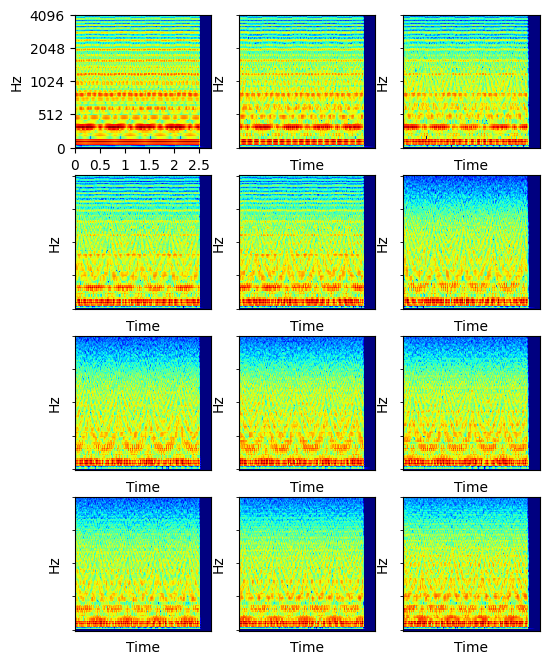

<Figure size 640x480 with 0 Axes>

In [12]:
# plot the spectrograms in a grid
spec_fig = plot_specs(specs,SAMPLE_RATE,4096)

In [13]:
# stack the lists into an np array
mfcc_features_stacked = np.stack(mfcc_features, axis=0)
musicnn_features_stacked = np.stack(musicnn_features, axis=0)
specs_stacked = np.stack(specs, axis=0)
raw_stacked = np.stack(raw_signals, axis=0)

# Normalize the MFCC and Musicnn feature datasets for fair comparison
mfcc_features_normalized = normalize_data(mfcc_features_stacked)
musicnn_features_normalized = normalize_data(musicnn_features_stacked)
raw_normalized = normalize_data(raw_stacked)
specs_normalized = normalize_data(specs_stacked)

# Compute the standard deviation of the elements in each list
baseline_raw = np.std(raw_normalized,axis=0)
baseline_spec = np.std(specs_normalized,axis=0)
mfcc_std = np.std(mfcc_features_normalized, axis=0)
musicnn_std = np.std(musicnn_features_normalized, axis=0)

# see which one has smallest distribution width
mfcc_total_diff = np.mean(mfcc_std)
musicnn_total_diff = np.mean(musicnn_std)
raw_total_diff = np.mean(baseline_raw)
spec_total_diff = np.mean(baseline_spec)

# put results into a dictionary
results = {
    'mfcc_total_diff':mfcc_total_diff,
    'musicnn_total_diff':musicnn_total_diff,
    'raw_total_diff':raw_total_diff,
    'spec_total_diff':spec_total_diff
}

std_results ={
    'mfcc_std_surface':mfcc_std,
    'musicnn_std_line':musicnn_std,
    'mfcc_feature_vectors':mfcc_features,
    'musicnn_feature_vectors':musicnn_features,
}

results

{'mfcc_total_diff': 0.00807794,
 'musicnn_total_diff': 0.04436586,
 'raw_total_diff': 0.09366115,
 'spec_total_diff': 0.066877626}

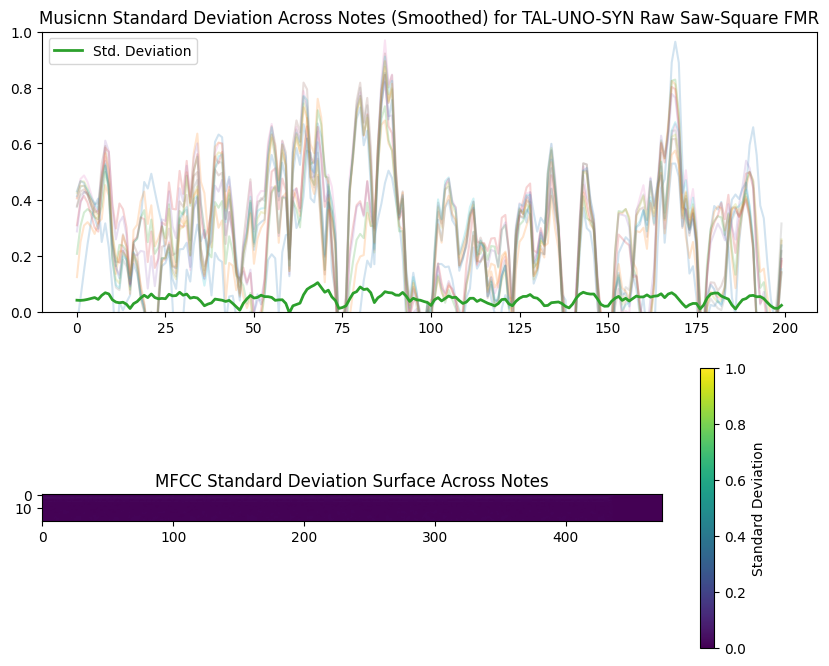

In [ ]:
# plot the standard deviation surface/line
fig, axes = plt.subplots(2,1,figsize=(10,8))

for line, note in zip(musicnn_features, NOTES):
    smoothed_line = savgol_filter(line, SMOOTHING_WINDOW_LENGTH, POLYORDER)
    axes[0].plot(smoothed_line, alpha=0.2)
smoothed_musicnn_std = savgol_filter(musicnn_std, SMOOTHING_WINDOW_LENGTH, POLYORDER)
axes[0].plot(smoothed_musicnn_std, linewidth=2, label='Std. Deviation')
axes[0].legend()
axes[0].set_title(f'Musicnn Standard Deviation Across Notes (Smoothed) for {out_name}')
axes[0].set_ylim([0,1])
# Plot MFCC standard deviation surface
axes[1].imshow(mfcc_std[:,:],vmin=0,vmax=1)
axes[1].set_title('MFCC Standard Deviation Surface Across Notes')

# Add a colorbar for the MFCC plot
cbar = fig.colorbar(axes[1].get_images()[0], ax=axes[1])
cbar.set_label('Standard Deviation')

# Show the plot
plt.show(block=False)

In [16]:
# save experimental results
save_name = os.path.join('results', EXP_NAME + f' [{out_name}]' + '.pt')
save_name2 = os.path.join('results',EXP_NAME + '-feature-data' + f' [{out_name}]' + '.pt')
torch.save(results,save_name)
torch.save(std_results,save_name2)
fig.savefig(os.path.join('results',f'{EXP_NAME}-{out_name}-figure.png'))